# Bank Marketing: Predict Who Will Subscribe a Term Deposit

### Author: Bo Chen

# Introduction



## Problem and Goal

The task is to predict if the client will subscribe a term deposit after direct marketing campaigns (phone calls) of a Portuguese banking institution. 

The dataset is acquired from [UCI](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#) and is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.


# Data Exploration

In [61]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.stats import boxcox
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score,recall_score, confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [17]:
#import data
bank = pd.read_csv("bank-full.csv", sep=";")
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [18]:
# look at main characters of the data and see if there is any missing values
bank.info()
bank.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [19]:
# Assessing if duplicated records are found in the dataset
bank.duplicated().sum()

0

# Exploratory Data Analysis (EDA)

## Describing the features

<AxesSubplot:xlabel='subscription', ylabel='count'>

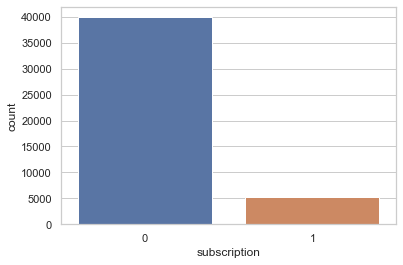

In [20]:
# change the name of y
bank.rename(index=str, columns={'y': 'subscription'}, inplace=True)
bank['subscription'] = bank['subscription'].apply(
    lambda x: 0 if x == 'no' else 1)
# replace number of days that passed by after the client was last contacted from a previous campaign
# 0 means the client has not been contacted
bank['pdays'] = bank['pdays'].apply(lambda x: 0 if x == -1 else x)
# Check the target variable
sns.set(style="whitegrid")
sns.countplot(bank['subscription'])

This a scaring imbalanced dataset, so we need to deal with this problem in the later stage.

In [21]:
rslt_dist = bank.subscription.value_counts(normalize=True)
print ("The subscription rate is {:.2f}% ".format(rslt_dist[1] * 100))

The subscription rate is 11.70% 


In [22]:
# Extract descriptive statistics
bank.describe()

,age,balance,day,duration,campaign,pdays,previous,subscription
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,41.015195,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,99.792615,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,0.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,0.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,0.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


In [23]:
bank.describe(include='O')

,job,marital,education,default,housing,loan,contact,month,poutcome
count,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959


We can appreciate that our features do not seem to be skewed as the mean and the median are roughly similar. This suggests that we would not need to transform our data, at least based on their distribution. Additionally, the range of each category is quite legitimate. However we notice that there are huge gaps between 75% and max, min and 25% value in the balance column, it is reasonable to doubt that outliers exist in the dataset.

### Identify Outliers using IQR rule

In [24]:
def identify_outlier(df, col):
    stat = df[col].describe()
    print(stat)
    IQR = stat['75%']-stat['25%']
    upper = stat['75%']+1.5*IQR
    lower = stat['25%']-1.5*IQR
    print('The upper and lower bounds for the potential outliers are {} and {}'.format(
        upper, lower))

In [25]:
# identify outliers for the age columns
identify_outlier(bank, "balance")

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64
The upper and lower bounds for the potential outliers are 3462.0 and -1962.0


In [26]:
bank1 = bank[(bank['balance'] < 3462) & (bank['balance'] > -1962)]
bank1

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscription
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,0,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,0,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,0,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,0,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45205,25,technician,single,secondary,no,505,no,yes,cellular,17,nov,386,2,0,0,unknown,1
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,0,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,0,0,unknown,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,0,0,unknown,0


## Descriptive Figures

### Distribution plots 

<AxesSubplot:xlabel='previous', ylabel='Density'>

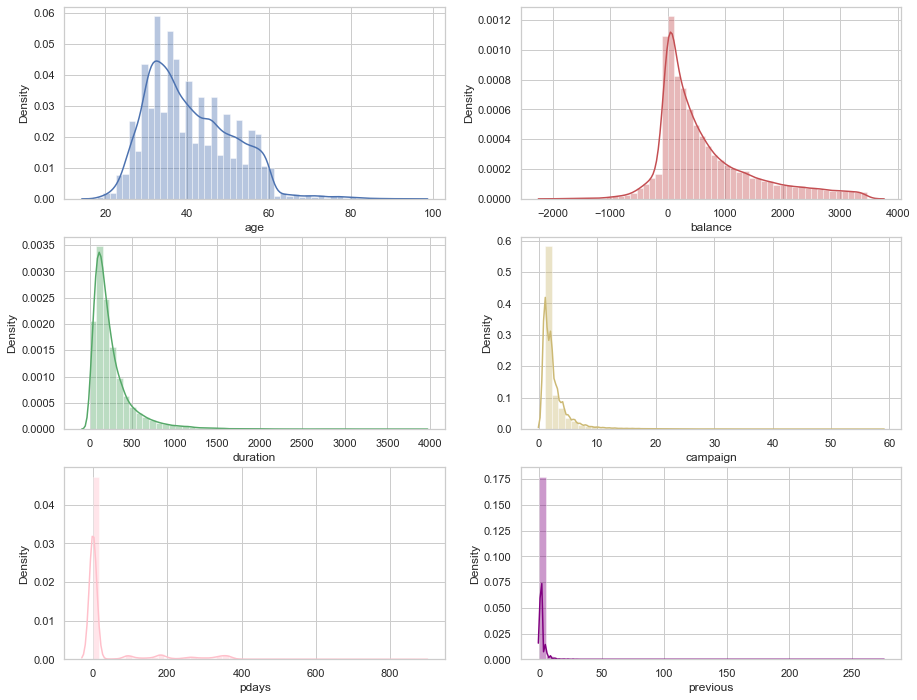

In [27]:
plt.figure(figsize=(15, 12))
plt.subplot(3, 2, 1)
sns.distplot(bank1['age'])
plt.subplot(3, 2, 2)
sns.distplot(bank1['balance'], color='r')
plt.subplot(3, 2, 3)
sns.distplot(bank1['duration'], color='g')
plt.subplot(3, 2, 4)
sns.distplot(bank1['campaign'], color='y')
plt.subplot(3, 2, 5)
sns.distplot(bank1['pdays'], color='pink', kde_kws={'bw': 0.1})
plt.subplot(3, 2, 6)
sns.distplot(bank1['previous'], color='purple', kde_kws={'bw': 0.1})

From the above distributions, we can observe that:
- The distribution of customer age is quite extensive, from 18 to 95. However, most of them are in the mid-age(30s-40s).
- The balance distribution is also wide spread, suggesting a large variability in customer balances.
- The duration of contact has a median about 300 seconds and most of them are very short, but there are still a number of large outliers which worth being investigated.
- Half of the clients were contacted by the bank for the second time and most of them are contacted by one to three times. However, some clients are contacted by 58 times at most, which is abnormal. It may be because these clients have special needs from the bank.
- Most clients are contacted recently or never been contacted and only a few has been contacted a few years ago.
- Most clients hasn't been contacted before this compaign and only a few get contacted many times.
- Furthermore, age, duration, previous and pdays are little bit skewed which could potentially bias our model later on. In a subsequent step, we will apply log transformation on these features.

### Scatter Matrix and Correlation Matrix

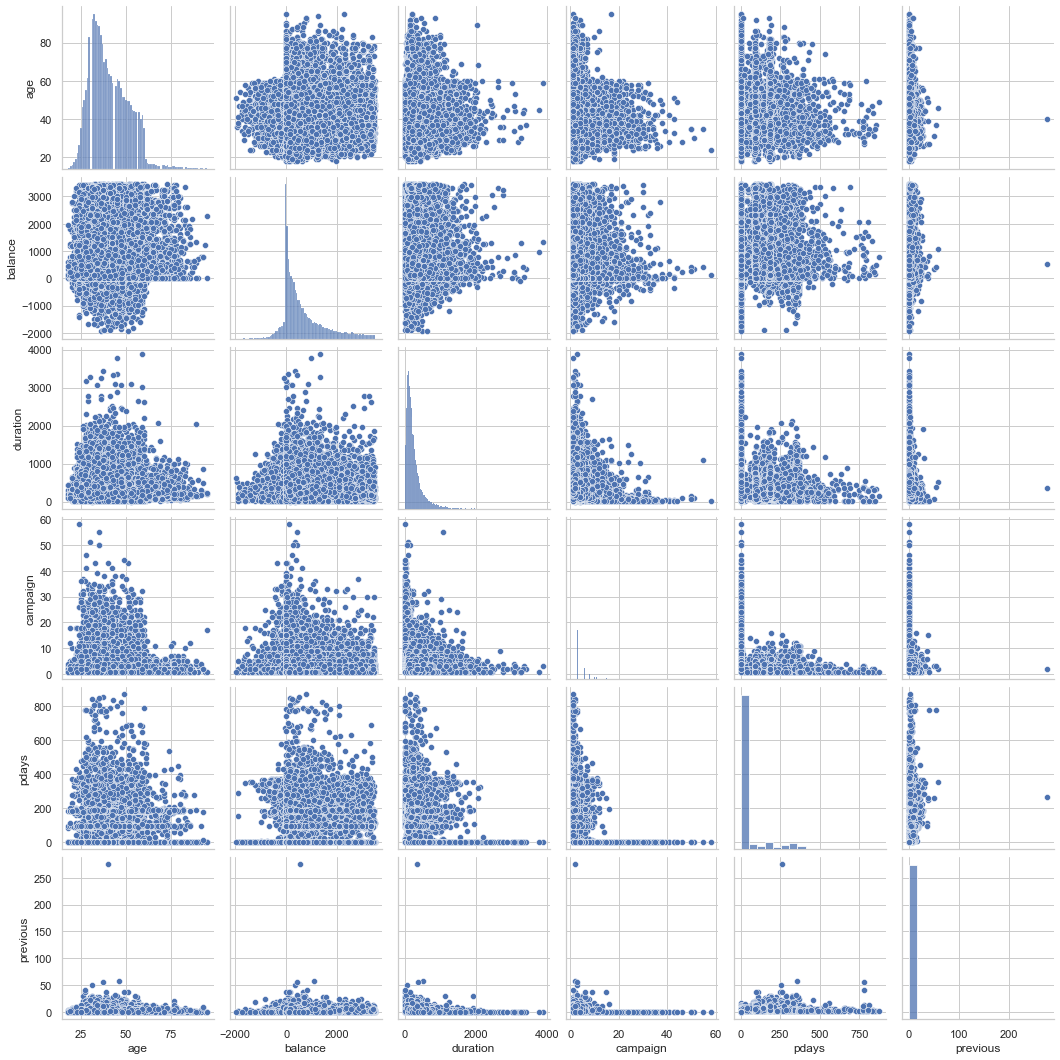

In [28]:
sns.pairplot(
    bank1[['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']])

Based on the above scatter matrix, we cannot find any valuable relationship among age, balance, duration, campaign, previous and pdays.

<AxesSubplot:>

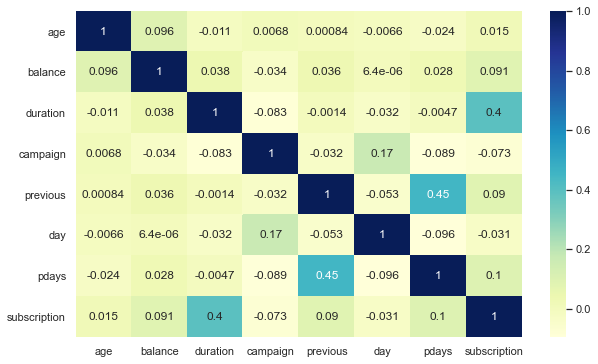

In [29]:
corr = bank1[['age', 'balance', 'duration', 'campaign',
              'previous', 'day', 'pdays', 'subscription']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap="YlGnBu", annot=True)

The cross-correlation revealed relatively strong relationship between our target feature and the last contact duration. There is also a mild correlation between subscription and pdays, balance or previous. The correlation is similar which is close to 0.1. Now, we would need to keep these relationship in mind since there seems to be some collinearity between the explanatory features as well(e.g. previous vs pdays, day vs campaign).

### Plots Regarding Target Feature

In [30]:
# Subsetting by subscriptions
sub_yes = bank1["subscription"] == 1
sub_no = bank1["subscription"] == 0

# Creating the plots
features = ["age", "balance", "duration",
            "pdays", "previous", "campaign", "day"]
labels = ["Subscription", "No Subscription"]

# create distribution plots for each numerical feature vs target variable


def create_distplots(features, labels):
    plt.figure(figsize=(15, 15))
    for ft in features:
        plt.subplot(4, 2, features.index(ft)+1)
        sns.distplot(bank1[ft][sub_yes], label=labels[0],
                     color="b", kde_kws={'bw': 0.1})
        sns.distplot(bank1[ft][sub_no], label=labels[1],
                     color="r", kde_kws={'bw': 0.1})
        plt.axvline(bank1[ft][sub_yes].mean(), linestyle='--', color="b")
        plt.axvline(bank1[ft][sub_no].mean(), linestyle='--', color="r")
        plt.legend()

# create violin plots for each numerical feature vs target variable


def create_violinplots(features):
    plt.figure(figsize=(15, 15))
    for ft in features:
        plt.subplot(4, 2, features.index(ft)+1)
        sns.violinplot(x=bank1['subscription'], y=bank1[ft])

### Violin plots with respect to target feature

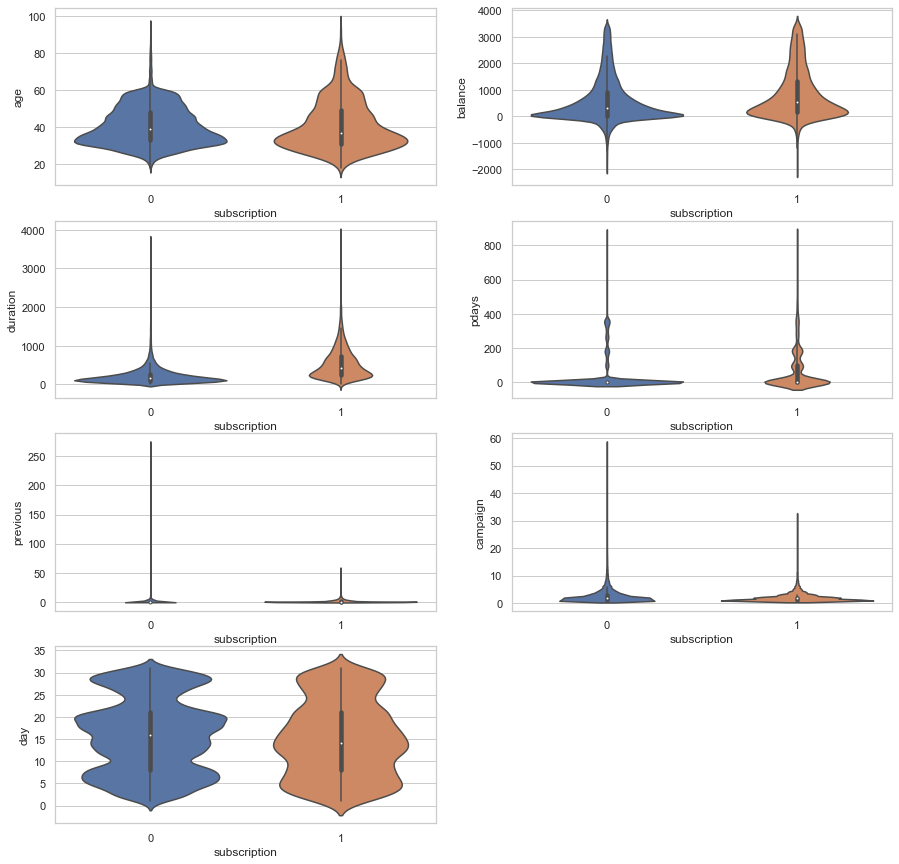

In [31]:
create_violinplots(features)

### Distribution plots  with respect to target feature

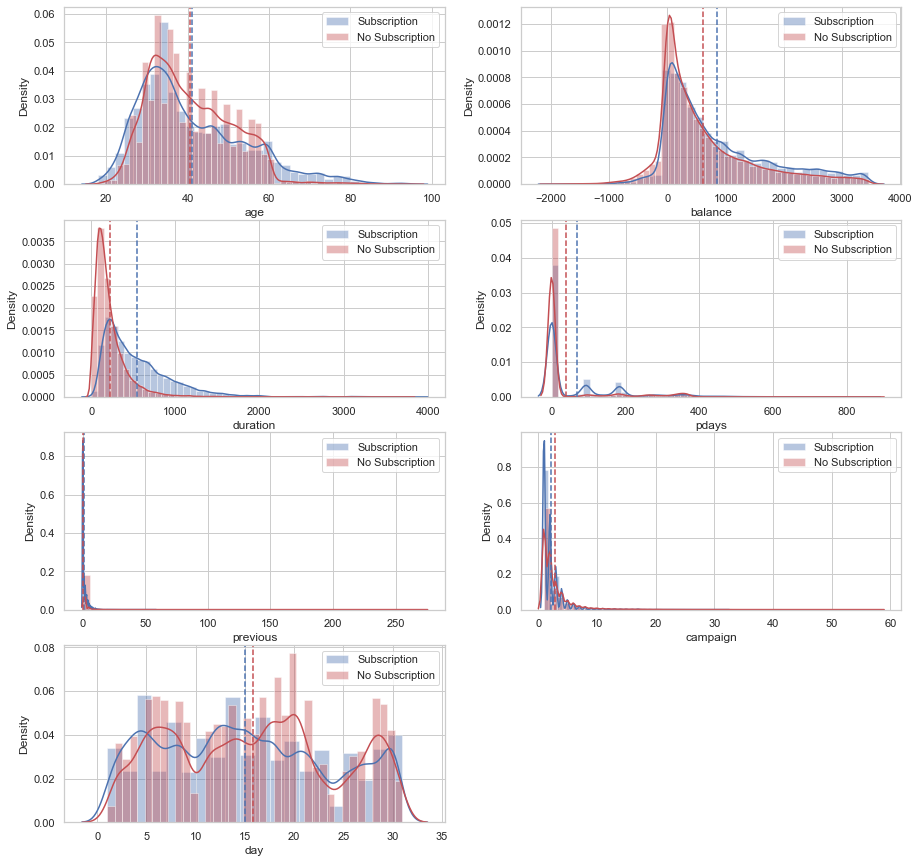

In [32]:
create_distplots(features, labels)

**Insights**
- Older and younger people are more likely to subscribe the term deposit. It makes sense since term deposit is the least risky investment which is suitable for these two groups of people.
- Clients with average or high balance are more likely to subscribe. In the future, the bank should focus more on these group of people.
- Longer contact duration is more likely to lead to a campaign success.
- People who have a contact period of about 150 days from contact by previous campaign are more likely to subscribe.
- There is no significant difference of subscription on last contact day of the month and number of contacts performed during and before this campaign.

### Barplots of categorical variables with repect to target variable

In [33]:
# get the probability of subscription based on the category and draw the barplot
def percent_sub(col):
    percent = bank1.groupby(
        [col])['subscription'].value_counts(normalize=True).rename(
            'percentage').mul(100).reset_index().sort_values('subscription')
    percent = percent[percent['subscription'] == 1]
    sns.barplot(x='percentage',
                y=col,
                data=percent,
                order=percent.sort_values('percentage', ascending=False)[col])

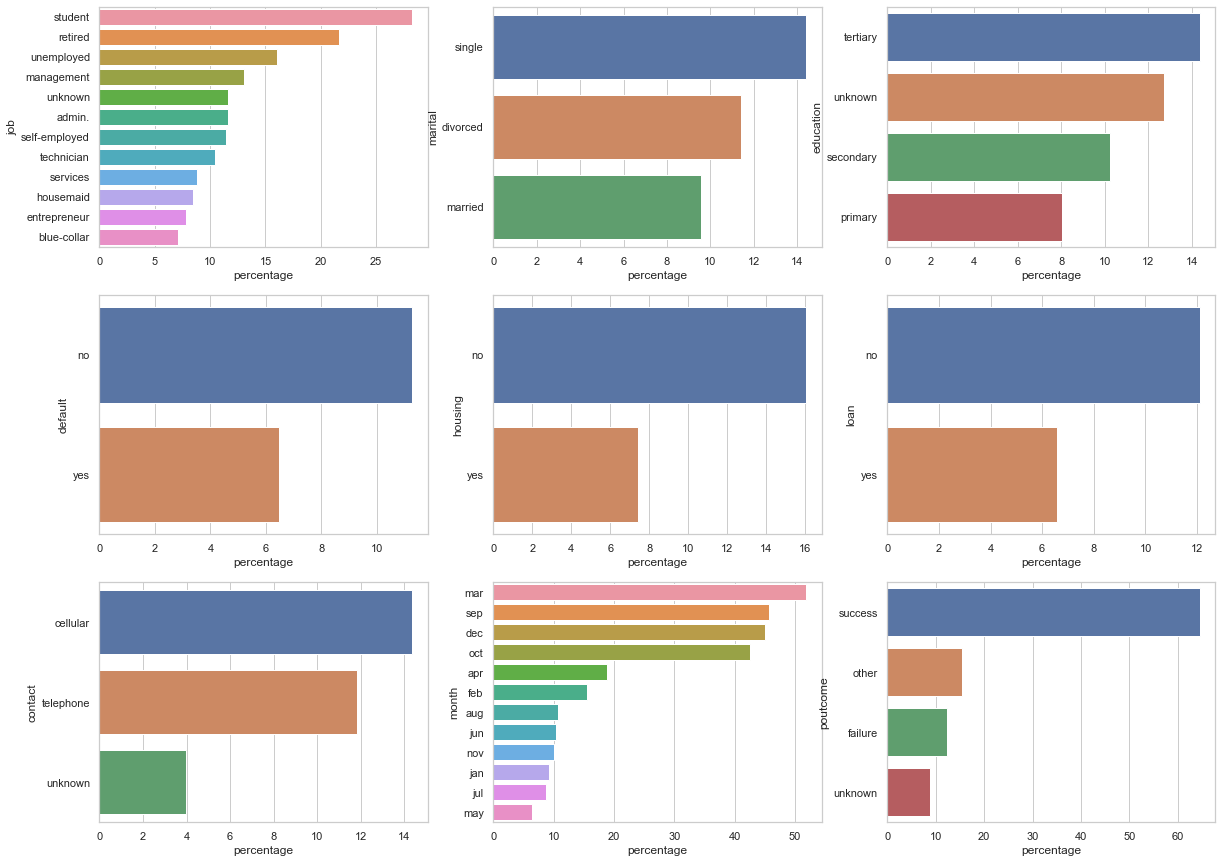

In [34]:
# plot each categorical feature
plt.figure(figsize=(20, 15))
cat_list = bank1.select_dtypes(exclude=['int64']).columns.tolist()
for ft in cat_list:
    plt.subplot(3, 3, cat_list.index(ft)+1)
    percent_sub(ft)

**Insights**
- Students and retirees are the major customers for the deposit description, which aligns with the previous finding about age.
- People with higher education tends to be more likely to subscribe.
- People who don't have credit in default or who don't have housing or personal loan should be targeted customers.
- The success of marketing campaign is largely affected by the effect of previous campaign.
- The marketing campaign is recommended to initiate during fall or spring as these two seasons seem to yield a better result.
- The contact method doesn't affect too much about client's choice of subscription.

# Feature Engineering

### Removing Unnecessary Features

As we observe from EDA part, the variables contact, day, campaign and previous do not affect the target variable too much, so they are removed.

In [35]:
bank1.drop(columns=['contact', 'day', 'campaign'], inplace=True)

### Skewed Features: Log Transform

Before machine learning, we are going to transform skewed variables to avoid future biases in the model. To potentially solve this issue, we will apply a logarithmic transformation to reduce the effect of outliers and reduce the distribution's range.

From EDA, we know that age, duration, pdays and previous should be adjusted to an unbiased level.

In [36]:
bank1['log_age'] = np.log(bank1['age'])
bank1['log_duration']=np.log(bank1['duration']+1)
bank1['log_pdays']=np.log(bank1['pdays']+1)
bank1['log_previous']=np.log(bank1['previous']+1)

### Standarization of Numerical Variables

In [37]:
#standarization numerical variables for better predicting.
num_list = bank1.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_list.remove('subscription')
df = bank1.copy()
df[num_list] = StandardScaler().fit_transform(df[num_list])
df.head()

,age,job,marital,education,default,balance,housing,loan,month,duration,pdays,previous,poutcome,subscription,log_age,log_duration,log_pdays,log_previous
0,1.659861,management,married,tertiary,no,1.779768,yes,no,may,0.018934,-0.407896,-0.244983,unknown,0,1.535409,0.437991,-0.462126,-0.420384
1,0.322248,technician,single,secondary,no,-0.724340,yes,no,may,-0.411584,-0.407896,-0.244983,unknown,0,0.442592,-0.153387,-0.462126,-0.420384
2,-0.728734,entrepreneur,married,secondary,no,-0.756322,yes,yes,may,-0.705119,-0.407896,-0.244983,unknown,0,-0.695435,-0.892062,-0.462126,-0.420384
3,0.608879,blue-collar,married,unknown,no,1.025219,yes,no,may,-0.642498,-0.407896,-0.244983,unknown,0,0.703512,-0.687000,-0.462126,-0.420384
4,-0.728734,unknown,single,unknown,no,-0.757507,no,no,may,-0.227635,-0.407896,-0.244983,unknown,0,-0.695435,0.139252,-0.462126,-0.420384


### drop unknown and other values

In [38]:
#remove NA values
df1 = df[(df['job'] != 'unknown') & (df['education'] != 'unknown') &
         (df['poutcome'] != 'unknown') & (df['poutcome'] != 'other')]
df1.head()

,age,job,marital,education,default,balance,housing,loan,month,duration,pdays,previous,poutcome,subscription,log_age,log_duration,log_pdays,log_previous
24060,-0.728734,admin.,married,tertiary,no,0.286069,no,no,oct,-0.849929,1.090129,1.049935,failure,0,-0.695435,-1.603421,1.999574,2.204840
24064,-0.728734,services,married,secondary,no,3.320848,yes,no,oct,-0.438980,0.494887,1.481575,failure,1,-0.695435,-0.204597,1.753549,2.627407
24077,-0.442102,management,married,tertiary,no,-0.758691,yes,no,oct,-0.454635,1.010763,1.049935,failure,1,-0.351231,-0.234981,1.973081,2.204840
24080,1.468773,technician,married,secondary,no,-0.061000,yes,no,oct,1.024781,1.050446,0.618296,success,1,1.396593,1.180450,1.986506,1.660057
24127,0.991054,admin.,single,secondary,no,2.951273,no,no,nov,0.754729,1.338146,0.186656,failure,0,1.026618,1.025502,2.074186,0.892228


### Processing Categorical Feature: Label Encoding

In [39]:
#label encoding on some of the categorical features because of logical relations
def bool_trans(data, col):
    data[col] = data[col].apply(lambda x: 1 if x == 'yes' else 0)
bool_trans(df1, 'default')
bool_trans(df1, 'housing')
bool_trans(df1, 'loan')
df1['poutcome'] = df1['poutcome'].apply(lambda x: 1 if x == 'success' else 0)
df1['month'] = df1['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5,
                                  'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
df1['month']=df1['month'].astype('int64')
df1.head()

,age,job,marital,education,default,balance,housing,loan,month,duration,pdays,previous,poutcome,subscription,log_age,log_duration,log_pdays,log_previous
24060,-0.728734,admin.,married,tertiary,0,0.286069,0,0,10,-0.849929,1.090129,1.049935,0,0,-0.695435,-1.603421,1.999574,2.204840
24064,-0.728734,services,married,secondary,0,3.320848,1,0,10,-0.438980,0.494887,1.481575,0,1,-0.695435,-0.204597,1.753549,2.627407
24077,-0.442102,management,married,tertiary,0,-0.758691,1,0,10,-0.454635,1.010763,1.049935,0,1,-0.351231,-0.234981,1.973081,2.204840
24080,1.468773,technician,married,secondary,0,-0.061000,1,0,10,1.024781,1.050446,0.618296,1,1,1.396593,1.180450,1.986506,1.660057
24127,0.991054,admin.,single,secondary,0,2.951273,0,0,11,0.754729,1.338146,0.186656,0,0,1.026618,1.025502,2.074186,0.892228


### Processing Categorical Feature: One Hot-Encoding

In [40]:
#one hot encoding for job and education
df_final = pd.get_dummies(df1)
# drop untransferred age column
df_final.drop(columns=['age','duration','pdays'], inplace=True)
df_final.head()

,default,balance,housing,loan,month,previous,poutcome,subscription,log_age,log_duration,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
24060,0,0.286069,0,0,10,1.049935,0,0,-0.695435,-1.603421,...,0,0,0,0,0,1,0,0,0,1
24064,0,3.320848,1,0,10,1.481575,0,1,-0.695435,-0.204597,...,1,0,0,0,0,1,0,0,1,0
24077,0,-0.758691,1,0,10,1.049935,0,1,-0.351231,-0.234981,...,0,0,0,0,0,1,0,0,0,1
24080,0,-0.061000,1,0,10,0.618296,1,1,1.396593,1.180450,...,0,0,1,0,0,1,0,0,1,0
24127,0,2.951273,0,0,11,0.186656,0,0,1.026618,1.025502,...,0,0,0,0,0,0,1,0,1,0


# Modeling

In this section, we will test various algorithms with our problem at hand to choose the best one in order to tune the model to its best parameters. In order to assess the different algorithms, we will use the metric **Precision** in this business case. Since we don't waste the money on the kind of people who will not subscribe the term deposit but the model tells us they will do so. We want to limit **False Positive** and **False Negative** does not cost so much since people who will subscribe the deposit but can't be captured by the model will bring profit anyway. Therefore, we need to develop an interpretable model that has a great **precision** to minimize the **false positive** which incur loss of money.

We are going to consider the following three classification models:
- logistic regression: the basic classification model and sometimes can do really well.
- random forest classification: fairly use all of our features and essentially reduce the overfitting problem.
- XGBoost: Focuses on learning the remaining errors (aka error fitting). In general, XGBoost is a lot faster than Sklearn's Gradient Boosting and has some built in regularization.

## Data Preparation

In [41]:
# separate explanatory and target variables
y = df_final['subscription']
X = df_final.drop(columns=['subscription'])

In [42]:
# Creating tran and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## Data Resampling (Upsample using SMOTE)

As we mentioned earlier, we have an imbalanced dataset. So we decide to use SMOTE to use the nearest neighbors of the minority observations to create new synthetic and balanced data.

In [43]:
#upsample using SMOTE
sm = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

## Baseline Model

Since we have an imbalanced dataset and the majority of data has a target of 0. We just simply predict 0 for the entire test set.

In [44]:
#baseline model based on intuition
Base=np.zeros(len(y_test))
precision_score(y_test,Base)

0.0

Unfortunately, we have a **zero** precision rate for our base model since we have no true postives here.

## Hyperparameter Tuning

In this part, we are going to do hyperparameter tuning for each model to find the maximum potential performance.

### Logistic Regression

In [572]:
#parameters for logistic regression
C = [float(x) for x in np.logspace(-4, 4, 20)]
penalty =['l1', 'l2']

In [573]:
#randomized search coss validation 
random_grid = {
    'C': n_estimators,
    'penalty': penalty,
}
lr = RandomizedSearchCV(LogisticRegression(),
                          param_distributions=random_grid,
                          n_iter=100,
                          cv=5,
                          verbose=2,
                          random_state=42,
                          n_jobs=-1,
                          scoring='precision')
lr.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [200, 400, 600, 800, 1000, 1200,
                                              1400, 1600, 1800, 2000],
                                        'penalty': ['l1', 'l2']},
                   random_state=42, scoring='precision', verbose=2)

In [575]:
# get the best model
lr.best_estimator_

LogisticRegression(C=800)

### Random Forest

In [567]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [568]:
# randomized search with hypothetical parameters
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
rfor = RandomizedSearchCV(RandomForestClassifier(),
                          param_distributions=random_grid,
                          n_iter=100,
                          cv=5,
                          verbose=2,
                          random_state=42,
                          n_jobs=-1,
                          scoring='precision')
rfor.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 27.8min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='precision', verbose=2)

In [569]:
# get the model with best performance
rfor.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=40, n_estimators=1400)

### XGBoost

Theoretically, optimal values of learning rate should be between 0.01-0.2). ESL states that the best strategy might be to set learning_rate low (<0.1) and then choose n_estimators by early stopping.In this case, we still take value 0.6 and 0.7 into account they really perform well.

In [578]:
# randomized search with potential parameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(3, 10)]   
gamma=[int(x) for x in np.linspace(0, 5)] 
param_grid_grad = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'gamma': gamma}
xgb_rs = RandomizedSearchCV(XGBClassifier(), param_distributions=param_grid_grad,
                     cv=5, n_jobs=-1, scoring='precision').fit(X_train_sm, y_train_sm)

In [579]:
# return the best model
xgb_rs.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=900, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Model Seletion

In this section, three models will be compared with their performance based on the precision metrics.

In [45]:
# get the mean and standard deviation precision score for each model
def cv_model(model, feature_df, target_df, precision, cv_std):
    score = cross_val_score(model, feature_df, target_df,
                            cv=5, scoring='precision')
    precision[model] = np.mean(score)
    cv_std[model] = np.std(score)

# Fit each model and get precision score and confusion matrix in the test set


def pred_model(model, precision_metrics, conf_matrix):
    fit = model.fit(X_train_sm, y_train_sm)
    precision_metrics[model] = precision_score(y_test, fit.predict(X_test))
    conf_matrix[model] = confusion_matrix(y_test, fit.predict(X_test))

# print all the metrics


def print_result(model, precision, cv_std, precision_metrics, conf_matrix):
    print('\nModel:\n', model)
    print('Mean Precision during CV:\n', precision[model])
    print('Standard deviation during CV:\n', cv_std[model])
    print('Precision in the Test Set:\n', precision_metrics[model])
    print('Confusion Matrix:\n', conf_matrix[model])

In [46]:
# create models -- hyperparameter tuning already done by GridSearch
models = []
precision = {}
cv_std = {}
precision_metrics = {}
conf_matrix = {}
lr = LogisticRegression(C=800, random_state=42)
rf = RandomForestClassifier(random_state=42, bootstrap=False, max_depth=40, n_estimators=1400)
xgb = XGBClassifier(max_depth=5, n_estimators=900,
                    random_state=42, learning_rate=0.2,gamma=0)
models.extend([lr, rf, xgb])

# parallel cross-validate models, using precision as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    cv_model(model, X_train_sm, y_train_sm, precision, cv_std)
    pred_model(model, precision_metrics, conf_matrix)
    print_result(model, precision, cv_std, precision_metrics, conf_matrix)

Beginning cross validation

Model:
 LogisticRegression(C=800, random_state=42)
Mean Precision during CV:
 0.8637482121523975
Standard deviation during CV:
 0.019221893716471587
Precision in the Test Set:
 0.6095890410958904
Confusion Matrix:
 [[706 114]
 [ 79 178]]

Model:
 RandomForestClassifier(bootstrap=False, max_depth=40, n_estimators=1400,
                       random_state=42)
Mean Precision during CV:
 0.8786712299154408
Standard deviation during CV:
 0.01449096272503206
Precision in the Test Set:
 0.6510791366906474
Confusion Matrix:
 [[723  97]
 [ 76 181]]

Model:
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=900, n_jobs=0, num_parallel_tree=1, random_

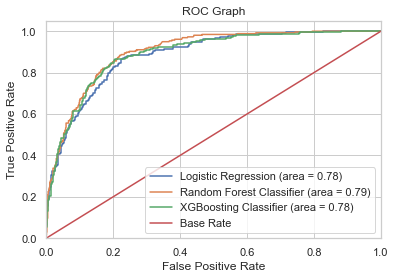

In [52]:
# Fit all three models
lr = lr.fit(X_train_sm, y_train_sm)
rf = rf.fit(X_train_sm, y_train_sm)
xgb = xgb.fit(X_train_sm, y_train_sm)

# Calculate roc_auc_score for each model prediction
lr_auc = roc_auc_score(y_test, lr.predict(X_test))
rf_auc = roc_auc_score(y_test, rf.predict(X_test))
xgb_auc = roc_auc_score(y_test, xgb.predict(X_test))

# Create ROC Graph
fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(
    y_test, rf.predict_proba(X_test)[:, 1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(
    y_test, xgb.predict_proba(X_test)[:, 1])


plt.figure()

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % lr_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier (area = %0.2f)' % rf_auc)


# Plot XGBoosting ROC
plt.plot(xgb_fpr, xgb_tpr, label='XGBoosting Classifier (area = %0.2f)' % xgb_auc)


# Plot Base Rate ROC
plt.plot([0, 1], [0, 1], label='Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

As we can see, random forest is the most successful model which effectively limit false positives.

## Feature Importances

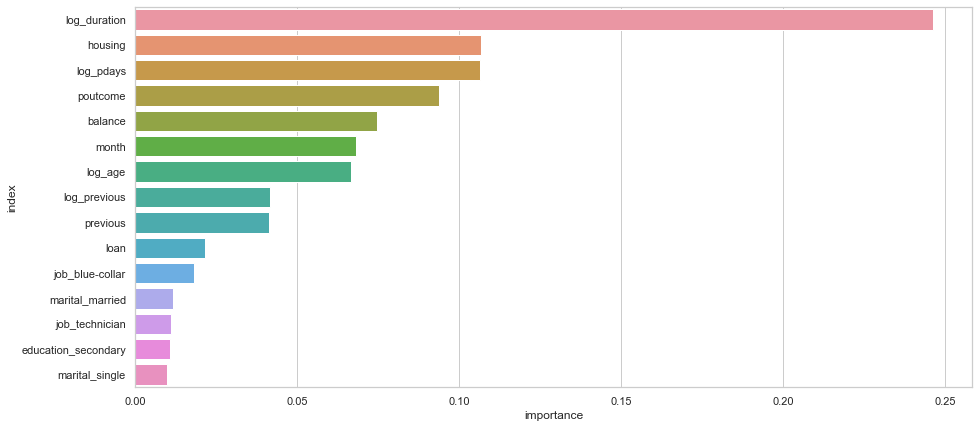

In [583]:
# Get feature importances
rf_importances = pd.DataFrame(rf.feature_importances_,
                              index=X_train.columns,
                              columns=['importance'
                                       ]).sort_values('importance',
                                                      ascending=False).reset_index()
plt.figure(figsize=(15, 7))
sns.barplot(x='importance', y='index', data=rf_importances[0:15])

## Model Insights

Now we can use our model to develop a new marketing strategy. Then the new email campaign strategy will be: only send email to users which my GBM model predicts positive.

In [62]:
ytest_pred=rf.predict(X_test)
print ("test precision: {:.2f}%".format(precision_score(y_test,ytest_pred) * 100))
print ("test recall: {:.2f}%".format(recall_score(y_test,ytest_pred) * 100))
n_calls_old = ytest_pred.shape[0]
n_calls_new = ytest_pred.sum()
saving_percentage = 100 - n_calls_new * 100.0/n_calls_old
pd.Series({'#calls made in old way': n_calls_old,
           '#calls  made in new way': n_calls_new,
           'saving percentage (%)': saving_percentage})

test precision: 65.11%
test recall: 70.43%


#calls made in old way     1077.000000
#calls  made in new way     278.000000
saving percentage (%)        74.187558
dtype: float64

according to its predictive result on test set:
- my model only need to do 26% of the old call amount, saving 74% amount.
- my model will cover 70% of valued users which will subscribe the deposit.
- 65.11% of the receiver will subscribe. compare with old strategy, whose subscription rate is 11.7% , my new strategy can be almost six times the subscription rate.

# Final Recommendations

## Target Customer

- Age: Young and old people (typically age<30 and age>60)
- Balance: People with relatively high balance (typically balance>1000)
- loan: People who do not have housing or private loans.
- Outcome from last campaign: People who indicate a successful outcome of the previous marketing campaign.
- Old customers: People who was previously get contacted before. 

## Seasonal Marketing

Marketing timing is an very essential for businesses. As we observe from EDA and feature importance, marketing seasons make a difference in results. It appears that spring and autumn marketing campaigns are the most successful. The bank should consider initiating its telemarketing campaign in fall and spring.

## Strategy Marketing

Marketing strategy is also key factor of success. Here is a tip to improve possibility of campaign success:
Try best to make the campaign engaging, so the customer is willing to participate in a long duration. Longer contact duration potentially indicates a success.